# Loading Data 

Para o experimentos foram escolhidos XXX movimentos que foram coletados da seguinte maneira:

Para cada postura de mão, o "subject" realizou cada movimento durante 5s por vez, com um intervalo de outros 5s para repouso, para um total de 10 repetições de cada gesto. Dessa forma, obtém-se 10 amostras de cada gesto de mão, cada uma durando 5 segundos, ou seja, 5000 pontos coletados. 

O repouso foi coletado de entre alguns dos movimentos.

Os movimentos são então separados ein:

0. gesture_0: hand resting | gesto 0: mão em repouso:
1. gesture_1: close hand   | gesto 1: mão fechada

<AxesSubplot:xlabel='X [s]'>

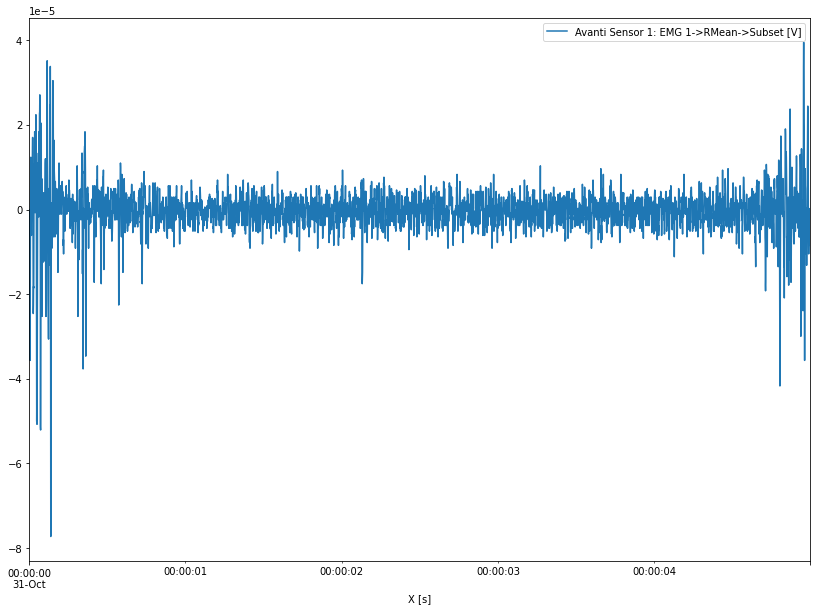

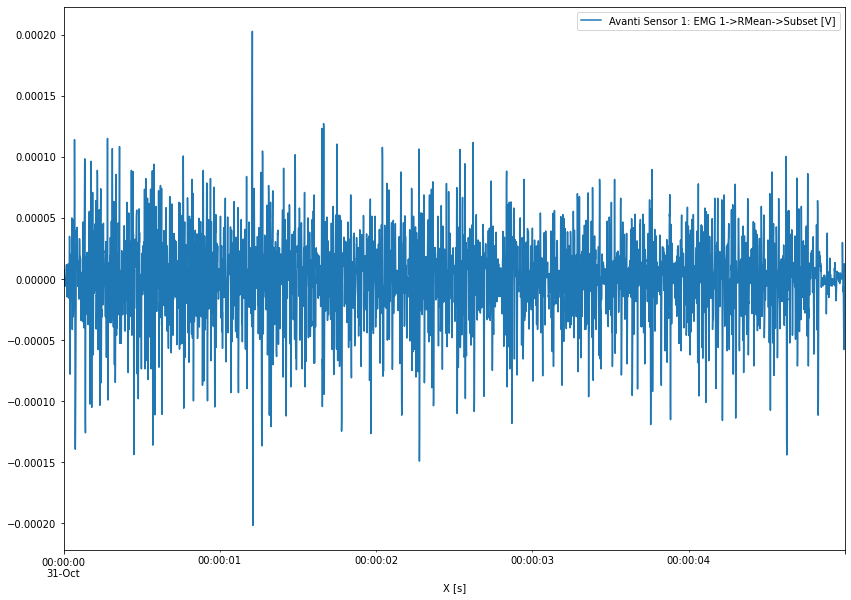

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import hmmlearn

gesture_samples = 2
n_gestures = 2
file_name = 'https://raw.githubusercontent.com/raphaelrcb/TCC_UnB/raphael_dev/data/gesture_0_1.csv'

# rest_hand_series = read_csv(file_name, header=1, usecols = [0,1], index_col = 0)
rest_hand_series = []
close_hand_series = []

for i in range(gesture_samples):
    rest_hand_file =    file_name[:len(file_name)-5] + str(i+1) + file_name[len(file_name)-4:]
    close_hand_file =   file_name[:len(file_name)-7] + "1_" + str(i+1) + file_name[len(file_name)-4:]
    # print(rest_hand_file)
    rest_hand_series.append(read_csv(rest_hand_file, header=1, usecols = [0,1], index_col = 0))
    rest_hand_series[i].index = pd.to_datetime(rest_hand_series[i].index, unit = 's', origin= 'unix')
    rest_hand_series[i].index = rest_hand_series[i].index.map(lambda t: t.replace(year=2021, month=10, day=31, hour=00))
    rest_hand_series[i].index = pd.DatetimeIndex(rest_hand_series[i].index).to_period('L')
    # print(close_hand_file)
    close_hand_series.append(read_csv(close_hand_file, header=1, usecols = [0,1], index_col = 0))
    close_hand_series[i].index = pd.to_datetime(close_hand_series[i].index, unit = 's', origin= 'unix')
    close_hand_series[i].index = close_hand_series[i].index.map(lambda t: t.replace(year=2021, month=10, day=31, hour=00))
    close_hand_series[i].index = pd.DatetimeIndex(close_hand_series[i].index).to_period('L')

# plt.figure(figsize=(14,10))
rest_hand_series[1].plot(figsize=(14,10))
close_hand_series[1].plot(figsize=(14,10))

# Segmenting Data

Como os dados para cada movimento foram coletados em uma única "rodada", ou seja, em uma coleta contínua para as 10 observações do gesto, é necessária uma segmentação manual para se separar apenas os 5s necessários de cada observação. Isso é feito offline através do software do delsys.

Como cada amostra de movimento dura 5s e é coletado numa freqûencia de 1000Hz, tem-se um total de 5000 pontos de dados, que podem ser divididos em janelas de 150ms com sobreposição de 50ms. Dessa forma, seguindo a fórmula

$$
N\; janelas = \frac{tamanho\: dos\,dados - tamanho\, da\, janela}{incremento\, da\,janela} + 1
$$

É possível obter um total de 98 janelas por segmento de dado.

In [2]:
data_size = len(close_hand_series[0])
window_size = 150
window_overlap = 50

n_windows = (data_size - window_size)/window_overlap + 1

print(n_windows)

rest_hand_window = []
close_hand_window = []

for j in range (gesture_samples):
    for i in range(int(n_windows)):
        rest_hand_window.append( rest_hand_series[j][(i*window_overlap):(i*window_overlap + window_size)] )
        close_hand_window.append( close_hand_series[j][(i*window_overlap):(i*window_overlap + window_size)] )

print(len(rest_hand_window))
print(len(close_hand_window))

98.0
196
196


# Feature Extraction

Dado que para cada gesto, obteve-se 98 janelas de dados, serão extraídas os coeficientes AR de quarta ordem de cada janela. Metade das janelas serão usadas para treinamento enquanto a outra metade será usada para testar o modelo.  

Se são 98 janelas por gesto, e cada gesto repetido 2 vezes, então tem-se 196 janelas. Define-se que 98 delas serão usadas para treinamento do HMM e as outras 98 para teste. Para o treinamento offline, os coeficientes AR de quarta ordem serão extraídos de cada janela, gerando 196 (98 x 2) vetores de características que possuem 4 dimensões no total.


In [11]:
# %%timeit
from statsmodels.tsa.arima.model import ARIMA

rest_features = []
close_features = []

for i in range(int(n_windows)*n_gestures):
    #extracting for rest gesture
    rest_model = ARIMA(rest_hand_window[i], order = (4,0,0))
    rest_fit   = rest_model.fit(method='yule_walker')
    rest_features.append(rest_fit.polynomial_ar)
    rest_features[i] = np.delete(rest_features[i], 0)
    rest_features[i] = -rest_features[i]
    # #extracting for close gesture
    close_model = ARIMA(close_hand_window[i], order = (4,0,0))
    close_fit   = close_model.fit(method='yule_walker')
    close_features.append(close_fit.polynomial_ar)
    close_features[i] = np.delete(close_features[i], 0)
    close_features[i] = -close_features[i]

print(i)
# close_features
# print(rest_fit.summary())
print(close_features[195])
n_features = len(rest_features)
print(n_features)

195
[ 1.07712418 -0.58437382  0.30631153 -0.21378555]
196


# Splitting Data between Train and Test

In [12]:
train_rest = []
test_rest = []

train_close = []
test_close = []

print(n_features)

print(int(n_features/2))
for i in range(int(n_features/2)):
    #Create Training Set
    train_rest.append( rest_features[i] )
    train_close.append( close_features[i] )
    #Create Test Set
    test_rest.append ( rest_features[  int(n_features/2) + i])
    test_close.append ( close_features[  int(n_features/2) + i])

lengths = [len(train_rest), len(train_close)]
X_train = np.concatenate([train_rest, train_close])
X_rest = test_rest
X_close = test_close

print(lengths)


196
98
[98, 98]


´´´
rest hand                                                       close hand
        0           5           30          60      90                  0              5        30      60      90      
L1 = 1.1050     =  0.9055   =  0.8249 =  0.9839 =  1.1135   | L1 =  1.4683      =  1.2648 =  1.3483 =  1.2895 =  1.4038 
L2 = -0.3798    = -0.3409   = -0.1025 = -0.4266 = -0.5778   | L2 = -1.0909      = -0.8506 = -1.0147 = -0.9046 = -1.1744
L3 = -0.0817    =  0.0115   =  0.0251 = -0.0081 =  0.1528   | L3 =  0.4278      =  0.1225 =  0.2858 =  0.2004 =  0.5062
L4 = 0.0126     = -0.1474   = -0.2659 = -0.0320 = -0.1106   | L4 = -0.2065      = -0.0804 = -0.0889 = -0.0473 = -0.1544


# Contrução do Modelo HMM

In [37]:
from hmmlearn import hmm
import matplotlib.pyplot as plt

def fit_hmm(n_components=2, n_mix=32):
    # try:
    startprob = np.zeros(n_components)
    startprob[0] = 1
    # print(startprob)
    # print("oh no")
    hmm_model = hmm.GMMHMM(n_components=n_components, 
                            n_mix=n_mix,
                            covariance_type="diag",
                            algorithm='viterbi', 
                            init_params="tmcw", params="tmcw")
    
    hmm_model.startprob_ = np.array(startprob)
    # print("oh no oh no")
    hmm_model.fit(X_train, lengths=lengths)
    # print("oh no oh no oh no")
    
    train_scores = []
    rest_scores = []
    close_scores = []

    # print(len(X_train))
    # print(len(X_rest))

    for i in range(len(X_train)):
        train_score = hmm_model.score(np.reshape(X_train[i],[len(X_train[i]),1]))
        train_scores.append(train_score)

    for j in range(len(X_rest)):
        rest_score = hmm_model.score(np.reshape(X_rest[j],[len(X_rest[j]),1]))
        rest_scores.append(rest_score)

    for j in range(len(X_close)):
        close_score = hmm_model.score(np.reshape(X_close[j],[len(X_close[j]),1]))
        close_scores.append(close_score)

    length_train = len(train_scores)
    length_rest = len(rest_scores) + length_train
    length_close = len(close_scores) + length_rest
 
    plt.figure(figsize=(14,10))
    plt.scatter(np.arange(length_train), train_scores, c='b', label='trainset')
    plt.scatter(np.arange(length_train, length_rest), rest_scores, c='r', label='rest')
    plt.scatter(np.arange(length_rest, length_close), close_scores, c='g', label='close')
    plt.title(f' HMM states: {n_components} | GMM components: {n_mix}')
    plt.legend(loc='lower right')
    plt.show()

    return hmm_model
    # Z2 = hmm_model.predict(X_train)
    # print(Z2)
    # except:
    #     pass

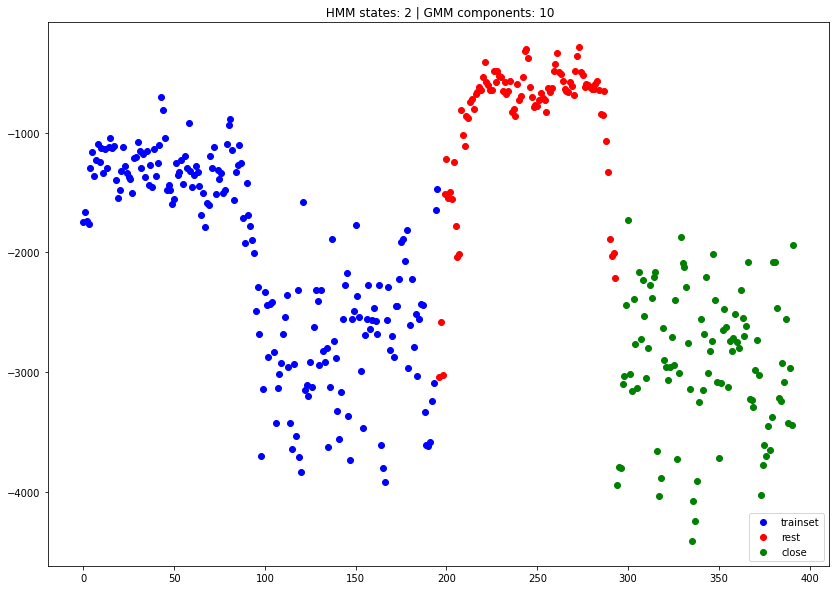

In [41]:
# fit_hmm(n_components=2, n_mix=1)
# fit_hmm(n_components=2, n_mix=2)
# fit_hmm(n_components=2, n_mix=3)
# fit_hmm(n_components=2, n_mix=4)
classifier = fit_hmm(n_components=2, n_mix=10)

# for z in range (len(X_close)):
#     hidden_states =  classifier.predict(np.reshape(X_[z],[len(X_[z]),1]))
#     print(hidden_states)

Tamanho dos Xtrain: 98
Tamanho dos Hstates: 98


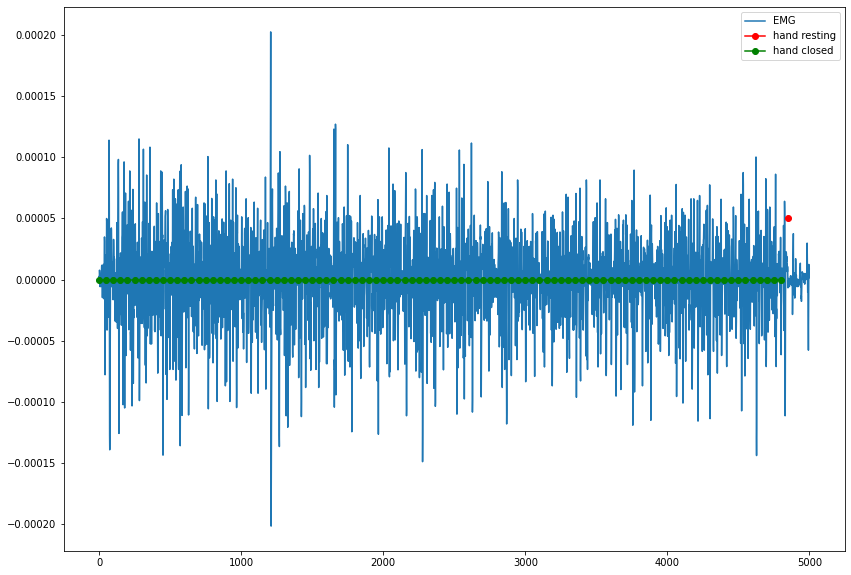

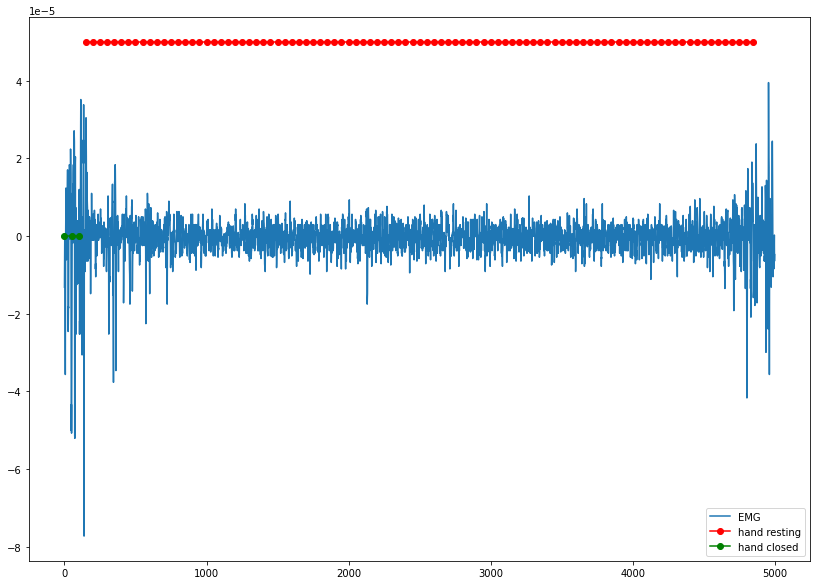

In [215]:
hidden_states = classifier.predict(X_close, len(X_close))
plot_series = close_hand_series[1].to_numpy()

print ("Tamanho dos Xtrain: " + str(len(X_close))) 
print ("Tamanho dos Hstates: " + str(len(hidden_states)))

plt.figure(figsize=(14,10))
# print(plot_series.flatten())
# print(plot_series.size)
 
plt.plot(np.arange(plot_series.size), plot_series.flatten(), label='EMG')

state_0 = np.ma.masked_where(hidden_states == 0, hidden_states)
state_1 = np.ma.masked_where(hidden_states == 1, hidden_states)

# plt.plot((np.arange(start=0, stop=len(hidden_states)*window_overlap, step=window_overlap)), (hidden_states)/20000, marker = 'o', linestyle='', c = 'r')
plt.plot((np.arange(start=0, stop=len(hidden_states)*window_overlap, step=window_overlap)), (state_0)/20000, marker = 'o', c = 'r', label='hand resting')
plt.plot((np.arange(start=0, stop=len(hidden_states)*window_overlap, step=window_overlap)), (state_1)/20000, marker = 'o', c= 'g', label='hand closed')
plt.legend()
plt.show()


hidden_states = classifier.predict(X_rest, len(X_rest))
plot_series = rest_hand_series[1].to_numpy()

# print ("Tamanho dos Xtrain: " + str(len(X_close))) 
# print ("Tamanho dos Hstates: " + str(len(hidden_states)))

plt.figure(figsize=(14,10))
# print(plot_series.flatten())
# print(plot_series.size)
 
plt.plot(np.arange(plot_series.size), plot_series.flatten(), label='EMG')

state_0 = np.ma.masked_where(hidden_states == 0, hidden_states)
state_1 = np.ma.masked_where(hidden_states == 1, hidden_states)

# plt.plot((np.arange(start=0, stop=len(hidden_states)*window_overlap, step=window_overlap)), (hidden_states)/20000, marker = 'o', linestyle='', c = 'r')
plt.plot((np.arange(start=0, stop=len(hidden_states)*window_overlap, step=window_overlap)), (state_0)/20000, marker = 'o', c = 'r', label='hand resting')
plt.plot((np.arange(start=0, stop=len(hidden_states)*window_overlap, step=window_overlap)), (state_1)/20000, marker = 'o', c= 'g', label='hand closed')
plt.legend()
plt.show()

In [179]:
hidden_states = classifier.predict(X_close, len(X_close))
acerto = 0
erro = 0

for i in range(len(hidden_states)):

    if (hidden_states[i] == 0):
        acerto+=1
    else:
        erro+=1

print("CLOSE HAND")
print("Acertos  = " + str(acerto))
print("Erros    = " + str(erro))
print("Acurácia = " + str( 100* (acerto/len(hidden_states)) ) + "%")

hidden_states = classifier.predict(X_rest, len(X_rest))
acerto = 0
erro = 0

for i in range(len(hidden_states)):

    if (hidden_states[i] == 1):
        acerto+=1
    else:
        erro+=1


print("REST HAND")
print("Acertos  = " + str(acerto))
print("Erros    = " + str(erro))
print("Acurácia = " + str( 100* (acerto/len(hidden_states)) ) + "%")




CLOSE HAND
Acertos  = 97
Erros    = 1
Acurácia = 98.9795918367347%
REST HAND
Acertos  = 95
Erros    = 3
Acurácia = 96.93877551020408%
